Todo:

Neue Implementation datasamplibg in xarray

- [ ] einfach über gesamtes Bild die targets erstellen mit coarsen
- [ ] dann nans auf 0 setzen
- [ ] durch meinen Filter jagen
- [ ] --> diejenigen mit vielen nans werden eh rausgefiltert
- [ ] dann wenn das input erstellt wird aus dem target funktion benutzen die einfach nan padded, alles was über die spatial bounds von unserem Datensatz geht (wird wh kaum passieren da unser datensatz ja quasi eh ge nan padded ist)

- [ ] Alternativ kann durch strengeres Filterkriterium auch einfach jedes Target mit irgendeinem Pixel als NaN rausgefiltert werden

Noch nicht gemacht:

AUGMENTATIONS:
- aus den Targets werden nur die Input frames erstellt, die dann alle an den data loader weitergegeben werden.
    - Diese frames enthalten NaNs, im trainings loop werden dann die NaNs auf 0 gesetzt für die Inputs und die Targets in one hot umgewandelt. 
- Die Inputs sind etwas größer als 256 x 256 mit einem 'augmentation padding' von ein paar pixeln. 
    - So kann innerhalb des trainingsloops mit torch random crop das eigentliche target erstellt werden innerhalb des Trainingsloops
    - Mit centercrop wird daraus dann das Traget erstellt
    - Auch andere image augmentations können genutzt werden ... 
    - Alle image augmentations (random crop, spiegel, ...) müssen für alle input frames und das target gleich sein! (gleichen seed setzen für random crop?)
    ! ACHTUNG ! Die Augmentation findet nicht im data loader statt, sondern erst im Trainings loop! Das Oversampling passiert aber auf dataloader ebene. Ist aber sinnvoll, da sich das Target von der Regenmenge her kaum ändert.

STATISTICS!
- Wir müssen noch die dataset statistics berechnen! Kann ich einfach schon den gefilterten (also maskierten) Datensatz nehmen und darauf mean und std direkt mit xarray berechnen?

ADDITINAL DATA SOURCES

- Nutze lat lon und datetime daten in den valid indecvies, sodass auf alle Daten mit dieser Projektion zugegriffen werden kann!

old:
- Still have to do the nan cropping in xarray: crop in picture such that it is no nan padded
- Put all data into RAM (first build calulation tree, with .compute it will be loaded into RAM)
- Decide on whether to load the 128 x 128 chunks (because going from 32 x 32 we would indeed have more data but it would be highly correlated so it is questionable whether it boosts performance, but will delay training in prototyping)
- Also decide on whether to use every time step as target or directly chunk time into patches with .coarsen()

In [157]:
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import zarr

In [158]:
folder_path = '/Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data' #'/home/jan/Programming/remote/first_CNN_on_radolan_remote/dwd_nc/own_test_data'
data = 'testdata_two_days_2019_01_01-02.zarr'
load_path = os.path.join(folder_path, data)
print(f'loading from: {load_path}')


loading from: /Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data/testdata_two_days_2019_01_01-02.zarr


In [159]:
num_input_frames = 4
lead_time = 4
pt = num_input_frames + lead_time # how many time steps to include in a sample (i.e. context and target)
# 
# This defines the size of the patches, that are created by coarsen, filter is applies to these patches
py, px = 32, 32 #73, 137 # how many pixels in y and x direction
y_input, x_input = 256, 256
y_input_padding, x_input_padding = 32, 32
threshold_mm_rain_each_pixel = 0.1 # threshold for each pixel filter condition
threshold_percentage_pixels = 0.5


# In the current implementation py and px define the size of the target patches (previously those were the larger input patches)
# length_width_center_even as the same size as py and px, as the filter condition is calculated on the target patches

In [160]:
data = xr.open_dataset(load_path, engine='zarr') # , chunks=None # , chunks=None according to Sebastian more efficient as it avoids dask (default is chunks=1)
# Simply reinstalled environment with numpy pandas xarray zarr jupyter
# Now not the same error as in first_CNN_on_Radolan env for some reason
data = data.squeeze()
# Cut off the beginning  of the data as the size of the data chunk, that one sample has (input frames + lead time + target)
data_shortened = data.isel(
    time=slice(pt, -1)
)

In [161]:
print(data.dims)

FrozenMappingWarningOnValuesAccess({'time': 576, 'y': 1200, 'x': 1100})


In [162]:
data_shortened.coords

Coordinates:
    latitude                (y, x) float64 11MB ...
    longitude               (y, x) float64 11MB ...
    missing_data_RV_recalc  (time) float32 2kB ...
    step                    timedelta64[ns] 8B 00:00:00
  * time                    (time) datetime64[ns] 5kB 2019-01-01T00:40:00 ......
  * x                       (x) float64 9kB -543.5 -542.5 -541.5 ... 554.5 555.5
  * y                       (y) float64 10kB -3.61e+03 -3.611e+03 ... -4.809e+03

In [163]:
# TODO: Crop the beginning of the data, such that we can always generate inputs from the target indecies


# partition the data into pt x py x px blocks using coarsen --> construct DatasetCoarsen object
# In this implementation each target corresponds to one patch
coarse = data_shortened.coarsen(
    y = py,
    x = px,
    # time = 1, # TODO: This way we are making patches with 4 subsequent time frames. This way we are only taking a target every 'pt'th time step
    side = "left", # "left" means that the blocks are aligned to the left of the input
    boundary="trim") # boundary="trim" removes the last block if it is too small
# construct a new data set, where the patches are folded into a new dimension
patches = coarse.construct(
    # time = ("time_outer", "time_inner"),
    y = ("y_outer", "y_inner"),
    x = ("x_outer", "x_inner"))
#Replace NaNs with 0s for the filter (we do not have to do this! Makes it less likely for the edge cases to occur in the target.)
# We also have the option to filter for NaNs in the input to completely prohibit edge cases
patches_no_nan = patches.fillna(0)

# --- FILTER ---
# define a threshold for each pixel --> we get a pixel-wise boo
patches_boolean_pixelwise = patches_no_nan > threshold_mm_rain_each_pixel
# We are calculating the percentage of pixels that passed filter (mean of boolean gives percentage of True) 
# --> we are getting rid of the patch dimensions y_inner and x_inner, 
patches_percentage_pixels_passed = patches_boolean_pixelwise.mean(("y_inner", "x_inner")) #, "time_inner"
# Now we are creating a boolean again by comparing the percentage of pixels that exceed the rain threshold to the minimally required 
# percentage of pixels that exceed the rain threshold
# --> valid_patches includes only the y_outer and x_outer, where each pair of indecies represents one patch. Its values are boolean, indicating whether or not the outer indecies correspond to a valid or invalid patch. 
valid_patches_boo = patches_percentage_pixels_passed > threshold_percentage_pixels


# get the outer coordinates for all valid blocks (valid_time, valid_x, valid_y)
# (valid_patches_boo is boolean, np.nonzero returns the indecies of the pixels that are non-zero, thus True)
valid_target_indecies_outer = np.array(np.nonzero(valid_patches_boo.RV_recalc.values)).T


### TODO: Calculate Statistics

Somehoe only choose the valid patches, flatten the whole data and calc statistics on that!

In [164]:
valid_patches_boo.where(True)

<xarray.Dataset> Size: 6MB
Dimensions:                 (time: 567, y_outer: 37, x_outer: 34)
Coordinates:
    missing_data_RV_recalc  (time) float32 2kB ...
    step                    timedelta64[ns] 8B 00:00:00
  * time                    (time) datetime64[ns] 5kB 2019-01-01T00:40:00 ......
Dimensions without coordinates: y_outer, x_outer
Data variables:
    RV_recalc               (time, y_outer, x_outer) float64 6MB 0.0 0.0 ... 0.0

In [165]:
valid_target_indecies_outer

array([[ 22,   5,  20],
       [ 23,   5,  20],
       [ 23,  12,  23],
       ...,
       [566,  25,  21],
       [566,  26,  21],
       [566,  30,  24]])

In [166]:
def valid_indecies_to_global_center_indecies(valid_target_indecies_outer, px, py, x_input, y_input):
    '''
    This functions converts the 'valid_target_indecies_outer' which give the outer indecies with respect to 'patches' to global indecies that refer to 'data_shortened'
    
    The time index of the input and output indecies always refer to the target frame, which the filtering was done on!
    In order to get the input time frames we have to change the time index in the unshortened dataset where the beginning was not clipped!
    '''
    valid_target_indecies_global = []
    valid_center_indecies_global = []
    valid_input_indecies_global = []
    
    for (time, y_inner, x_inner) in valid_target_indecies_outer:
        
        y_global_upper = y_inner * py
        x_global_left = x_inner * px
        
        # Calculate the global indecies / slices for the targets
        slice_y_global = slice(y_global_upper, y_global_upper + py)
        slice_x_global = slice(x_global_left, x_global_left + px)
        target_slices = [time, slice_y_global, slice_x_global]
        valid_target_indecies_global.append(target_slices)
        
        # Calculate indecies of the patche's center pixels
        center_y_global = y_global_upper + py // 2
        center_x_global = x_global_left + px // 2
        global_center_indecies = [time, center_y_global, center_x_global]
        valid_center_indecies_global.append(global_center_indecies)
        
        # Calculate the global slices for input
        # TODO: make sure this does not go out of bounds, create NAN padding of some sort in case the input size exceeds the nan bounds
        y_slice_input = slice(center_y_global - (y_input // 2), center_y_global + (y_input // 2))
        x_slice_input = slice(center_x_global - (x_input // 2), center_x_global + (x_input // 2))
        input_slices = [time, y_slice_input, x_slice_input]
        valid_input_indecies_global.append(input_slices)
         
    return np.array(valid_input_indecies_global), np.array(valid_target_indecies_global), np.array(valid_center_indecies_global)

In [167]:
valid_input_indecies_global, valid_target_indecies_global, valid_center_indecies_global = valid_indecies_to_global_center_indecies(valid_target_indecies_outer, px, py, y_input + y_input_padding, x_input + x_input_padding)

### CONVERT INDECIES TO Coords

In [168]:
# REWRITE TO CONVERT INDECIES TO coords
def valid_indecies_to_global_center_indecies(data_shortened, valid_target_indecies_outer, px, py, x_input, y_input):
    '''
    This functions converts the 'valid_target_indecies_outer' which give the outer indecies with respect to 'patches' to global indecies that refer to 'data_shortened'
    
    The time index of the input and output indecies always refer to the target frame, which the filtering was done on!
    In order to get the input time frames we have to change the time index in the unshortened dataset where the beginning was not clipped!
    
    The patches where the larger input patch exceeds the bounds of data_shortened are dropped! therefore the outputs are shorter than valid_target_indecies_outer
    '''
    valid_target_indecies_global = [] 
    valid_center_indecies_global = []
    valid_input_indecies_global = []
    valid_input_coords = [] # These are defined 
    
    
    num_inputs_exceeding_bounds = 0
    
    for (time, y_outer, x_outer) in valid_target_indecies_outer:
        
        y_global_upper = y_outer * py
        x_global_left = x_outer * px
        
        # Calculate the global indecies / slices for the targets
        # TODO I think this can be removed in future
        slice_y_global = slice(y_global_upper, y_global_upper + py)
        slice_x_global = slice(x_global_left, x_global_left + px)
        target_slices = [time, slice_y_global, slice_x_global]
        
        # Calculate indecies of the patche's center pixels
        center_y_global = y_global_upper + py // 2
        center_x_global = x_global_left + px // 2
        global_center_indecies = [time, center_y_global, center_x_global]
        
        # Calculate the global slices for input
        y_slice_input = slice(center_y_global - (y_input // 2), center_y_global + (y_input // 2))
        x_slice_input = slice(center_x_global - (x_input // 2), center_x_global + (x_input // 2))
        input_slices = [time, y_slice_input, x_slice_input]
        
        # Check if the larger input exceeds size, if not append the patch indecies / slices to the list
        if y_slice_input.start < 0 or y_slice_input.stop >= data_shortened.sizes['y'] or x_slice_input.start < 0 or x_slice_input.stop >= data_shortened.sizes['x']:
            num_inputs_exceeding_bounds += 1
            continue # Skips the rest of the loop if input frame exceeds dataset bounds
                
        # Convert indecies to coordinates
        # TODO: Is there a better way to do this?
        time_datetime = data_shortened.time.isel(time=time).values
        
        y_coords_input = data_shortened.y.isel(y=y_slice_input).values
        x_coords_input = data_shortened.x.isel(x=x_slice_input).values
        
        y_coords_slices_input = slice(y_coords_input[0], y_coords_input[-1])
        x_coords_slices_input = slice(x_coords_input[0], x_coords_input[-1])
        
        input_coords = [time_datetime, y_coords_slices_input, x_coords_slices_input]
    
        
        valid_target_indecies_global.append(target_slices)
        valid_center_indecies_global.append(global_center_indecies)
        valid_input_indecies_global.append(input_slices)
        valid_input_coords.append(input_coords)
        
    print(f'{num_inputs_exceeding_bounds} patches dropped as input exceeded spatial data bounds')    
    return (
        np.array(valid_input_coords),
        np.array(valid_input_indecies_global),
        np.array(valid_target_indecies_global),
        np.array(valid_center_indecies_global))

In [169]:
valid_input_coords, valid_input_indecies_global, valid_target_indecies_global, valid_center_indecies_global = valid_indecies_to_global_center_indecies(
    data_shortened, valid_target_indecies_outer, px, py, y_input + y_input_padding, x_input + x_input_padding)

418 patches dropped as input exceeded spatial data bounds


In [170]:
valid_input_coords[0,0]

np.datetime64('2019-01-01T02:30:00.000000000')

In [211]:
def get_frames_from_coords(input_coord, data, num_input_frames, lead_time, time_step_data_minutes=5):
    '''
    This function takes in the coordinates 'input_coord' 
        Each input_coord represents one patch that passed the filter.
        The spatial slices in input_coord have the spatial size of the input + the augmentation padding 
        The temporal datetime point gives the time of the target frame (as the filter was applied to the target)
        Therefore to get the inputs we have to go back in time relative to the given time in input_coord (depending on lead time and num_input_frames)
    
    Returns the input and target patches. Both the input and the target patches are in the size of    
    '''

    
    # Make sure this is an int:
    num_input_frames = int(num_input_frames)
    lead_time = int(lead_time)
    
    # extract coordinates / coordinat slices
    time, y_slice, x_slice = input_coord
    
    # TODO: Chooses one infput too much!
    # Go back in time to get the time slice of the input
    input_start = time - np.timedelta64(time_step_data_minutes * (num_input_frames + lead_time), 'm')
    input_end = time - np.timedelta64(time_step_data_minutes * lead_time, 'm')
    
    time_slice_input = slice(input_start, input_end)
    time_coord_target = time
    
    # Generate input and output data
    input = data.sel(
        time = time_slice_input,
        y = y_slice,
        x = x_slice,
    )
    input_values = input.RV_recalc.values
    
    target = data.sel(
        time = time_coord_target,
        y = y_slice,
        x = x_slice,
    )
    target_values = target.RV_recalc.values
    
    return input_values, target_values


In [212]:
""

''

# Test Stuff

In [213]:
rand_coord_idx = np.random.randint(0, valid_input_coords.shape[0])

##### Test get_patches_from_coords

In [214]:
coord = valid_input_coords[rand_coord_idx]
input_frames, target_frame = get_frames_from_coords(coord, data, num_input_frames, lead_time)

In [215]:
np.timedelta64(5, 'm')

np.timedelta64(5,'m')

In [216]:
coord[0]

np.datetime64('2019-01-02T02:50:00.000000000')

In [217]:
input_frames

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ..

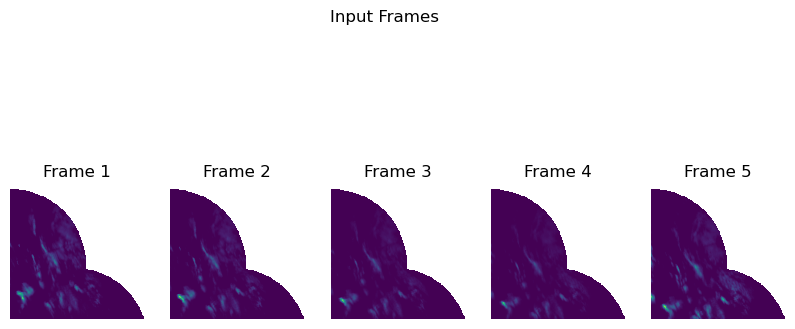

In [218]:
num_frames = input_frames.shape[0]  # This should be 4 as per your description

plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
for i in range(num_frames):
    plt.subplot(1, num_frames, i + 1)  # 1 row, num_frames columns, i+1 is the subplot index
    plt.imshow(input_frames[i, :, :], cmap='viridis')  # Show the ith frame
    plt.title(f'Frame {i+1}')  # Title for each subplot
    plt.axis('off')  # Hide the axis

plt.suptitle('Input Frames')  # Super title for the entire figure
plt.show()  # Display the plot

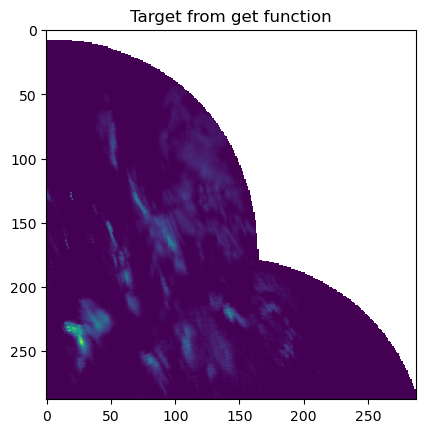

In [219]:
plt.figure()
plt.title('Target from get function')
plt.imshow(input_frames[0,:,:], cmap='viridis')

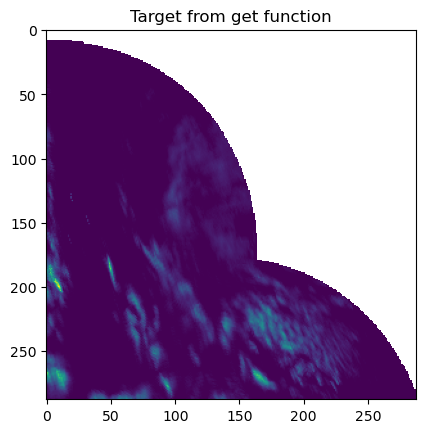

In [220]:
plt.figure()
plt.title('Target from get function')
plt.imshow(target_frame, cmap='viridis')

### Test valid_indecies_to_global_center_indecies

In [179]:
valid_input_indecies_global


array([[np.int64(22), slice(np.int64(32), np.int64(320), None),
        slice(np.int64(512), np.int64(800), None)],
       [np.int64(23), slice(np.int64(32), np.int64(320), None),
        slice(np.int64(512), np.int64(800), None)],
       [np.int64(23), slice(np.int64(256), np.int64(544), None),
        slice(np.int64(608), np.int64(896), None)],
       ...,
       [np.int64(566), slice(np.int64(672), np.int64(960), None),
        slice(np.int64(544), np.int64(832), None)],
       [np.int64(566), slice(np.int64(704), np.int64(992), None),
        slice(np.int64(544), np.int64(832), None)],
       [np.int64(566), slice(np.int64(832), np.int64(1120), None),
        slice(np.int64(640), np.int64(928), None)]], dtype=object)

In [180]:
sample_coord = valid_input_coords[rand_coord_idx]
# get the block at the sample coordinate. We are operating on the outer coordinates of the coarsed dataset
sample_block = data_shortened.sel(
    # time_outer = sample_coord[0],
    time = sample_coord[0],
    y = sample_coord[1],
    x = sample_coord[2])

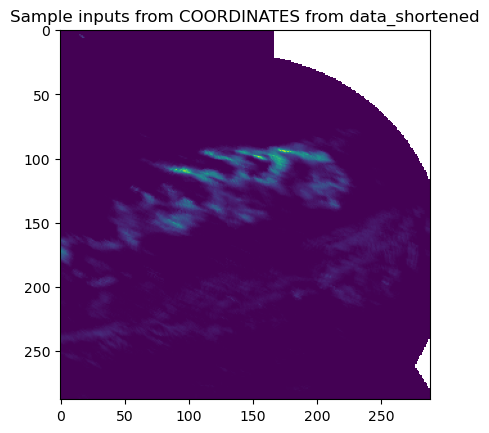

In [181]:
sample_block_vals = sample_block.RV_recalc.values.squeeze()
plt.figure()
plt.title('Sample inputs from COORDINATES from data_shortened')
plt.imshow(sample_block_vals, cmap='viridis')

In [182]:
sample_coord = valid_input_coords[rand_coord_idx]
# get the block at the sample coordinate. We are operating on the outer coordinates of the coarsed dataset
sample_block = data.sel(
    # time_outer = sample_coord[0],
    time = sample_coord[0],
    y = sample_coord[1],
    x = sample_coord[2])

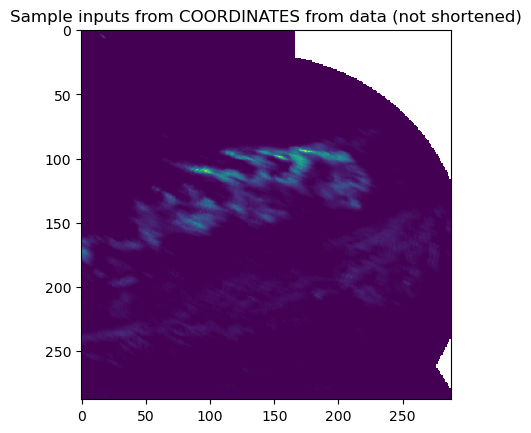

In [183]:
sample_block_vals = sample_block.RV_recalc.values.squeeze()
plt.figure()
plt.title('Sample inputs from COORDINATES from data (not shortened)')
plt.imshow(sample_block_vals, cmap='viridis')

In [184]:
sample_coord = valid_input_indecies_global[rand_coord_idx]
# get the block at the sample coordinate. We are operating on the outer coordinates of the coarsed dataset
sample_block = data_shortened.isel(
    # time_outer = sample_coord[0],
    time = sample_coord[0],
    y = sample_coord[1],
    x = sample_coord[2])

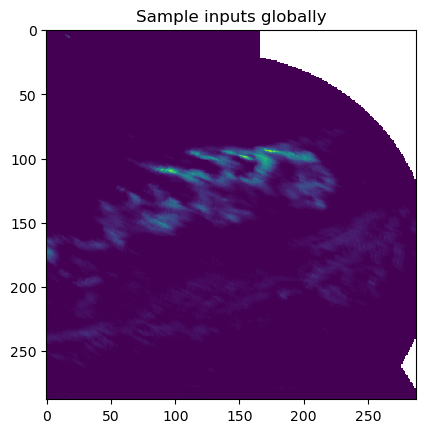

In [185]:
sample_block_vals = sample_block.RV_recalc.values.squeeze()
plt.figure()
plt.title('Sample inputs globally')
plt.imshow(sample_block_vals, cmap='viridis')

In [186]:
sample_coord = valid_target_indecies_global[rand_coord_idx]
# get the block at the sample coordinate. We are operating on the outer coordinates of the coarsed dataset
sample_block = data_shortened.isel(
    # time_outer = sample_coord[0],
    time = sample_coord[0],
    y = sample_coord[1],
    x = sample_coord[2])

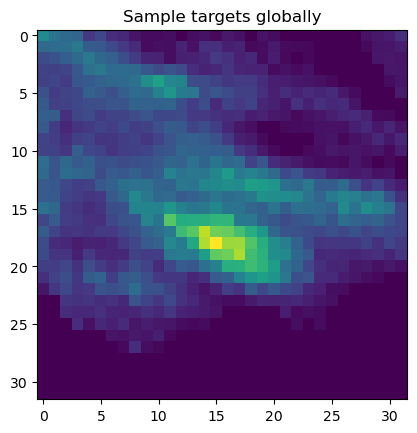

In [187]:
sample_block_vals = sample_block.RV_recalc.values.squeeze()
plt.figure()
plt.title('Sample targets globally')
plt.imshow(sample_block_vals, cmap='viridis')

In [188]:
# SAMPLE DIRECTLY THROUGH INNER indecies FROM 'patches'
# THIS TEST TURNED OUT POSITIVE BEFORE PATCHES THAT EXCEED BOUNDS WERE DROPPED SO ALL GOOD

# For data loading purposes, we can use the valid_indecies to get the corresponding blocks
# For example, to get a random block from the valid blocks, we can do the following:
# get a random element from the valid coordinates
sample_coord = valid_target_indecies_outer[rand_coord_idx]
# get the block at the sample coordinate. We are operating on the outer coordinates of the coarsed dataset
sample_block = patches.isel(
    # time_outer = sample_coord[0],
    time = sample_coord[0],
    y_outer = sample_coord[1],
    x_outer = sample_coord[2])
# Squeeze time dimension, which has len 1
# sample_block = sample_block.squeeze()

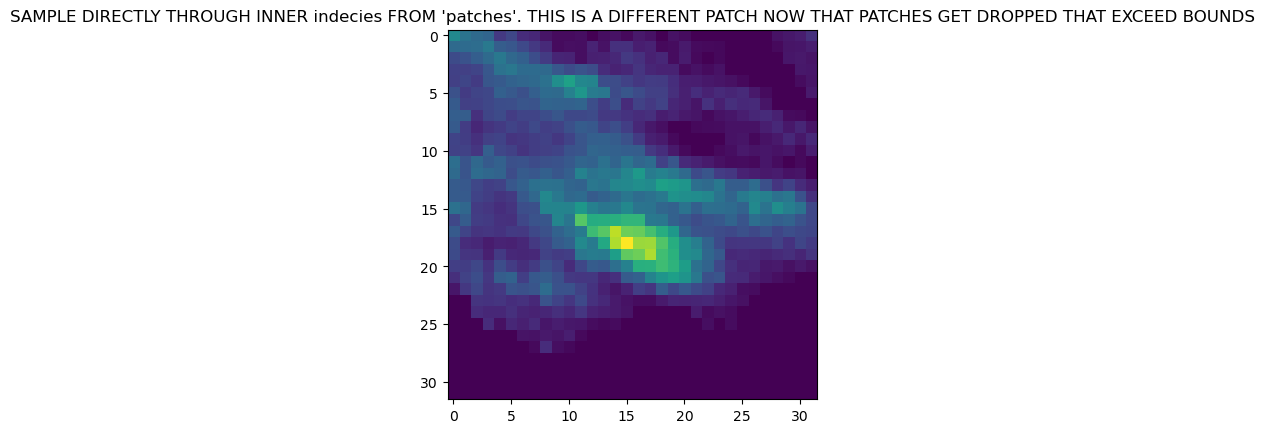

In [189]:
sample_block_vals = sample_block.RV_recalc.values.squeeze()
plt.figure()
plt.title("SAMPLE DIRECTLY THROUGH INNER indecies FROM 'patches'. THIS IS A DIFFERENT PATCH NOW THAT PATCHES GET DROPPED THAT EXCEED BOUNDS")
plt.imshow(sample_block_vals, cmap='viridis')

# group by day xarray --> group by day to split in training and validation

### Test converting indecies to coors

In [190]:
time, y_outer, x_outer = sample_coord

y_global_upper = y_outer * py
x_global_left = x_outer * px

# Calculate the global indecies / slices for the targets
slice_y_global = slice(y_global_upper, y_global_upper + py)
slice_x_global = slice(x_global_left, x_global_left + px)
target_slices = [time, slice_y_global, slice_x_global]

# Calculate indecies of the patche's center pixels
center_y_global = y_global_upper + py // 2
center_x_global = x_global_left + px // 2
global_center_indecies = [time, center_y_global, center_x_global]

# Calculate the global slices for input
# TODO: make sure this does not go out of bounds, create NAN padding of some sort in case the input size exceeds the nan bounds
y_slice_input = slice(center_y_global - (y_input // 2), center_y_global + (y_input // 2))
x_slice_input = slice(center_x_global - (x_input // 2), center_x_global + (x_input // 2))
input_slices = [time, y_slice_input, x_slice_input]

# Convert indecies to coordinates
patch = data_shortened.isel(
    time = time,
    y = y_slice_input,
    x = x_slice_input,
)

# Step 1: Extract the coordinate values at the indices
time_value = data_shortened.time.isel(time=time).values
lat_values = data_shortened.y.isel(y=y_slice_input).values
lon_values = data_shortened.x.isel(x=x_slice_input).values

# Step 2: Use these values to select data with sel
patch_from_coords = data_shortened.sel(
    time=time_value,
    y=slice(lat_values[0], lat_values[-1]),
    x=slice(lon_values[0], lon_values[-1]))

In [191]:
time_value

np.datetime64('2019-01-01T09:05:00.000000000')

In [192]:
lat_values

array([-3849.64472427, -3850.64472427, -3851.64472427, -3852.64472427,
       -3853.64472427, -3854.64472427, -3855.64472427, -3856.64472427,
       -3857.64472427, -3858.64472427, -3859.64472427, -3860.64472427,
       -3861.64472427, -3862.64472427, -3863.64472427, -3864.64472427,
       -3865.64472427, -3866.64472427, -3867.64472427, -3868.64472427,
       -3869.64472427, -3870.64472427, -3871.64472427, -3872.64472427,
       -3873.64472427, -3874.64472427, -3875.64472427, -3876.64472427,
       -3877.64472427, -3878.64472427, -3879.64472427, -3880.64472427,
       -3881.64472427, -3882.64472427, -3883.64472427, -3884.64472427,
       -3885.64472427, -3886.64472427, -3887.64472427, -3888.64472427,
       -3889.64472427, -3890.64472427, -3891.64472427, -3892.64472427,
       -3893.64472427, -3894.64472427, -3895.64472427, -3896.64472427,
       -3897.64472427, -3898.64472427, -3899.64472427, -3900.64472427,
       -3901.64472427, -3902.64472427, -3903.64472427, -3904.64472427,
      

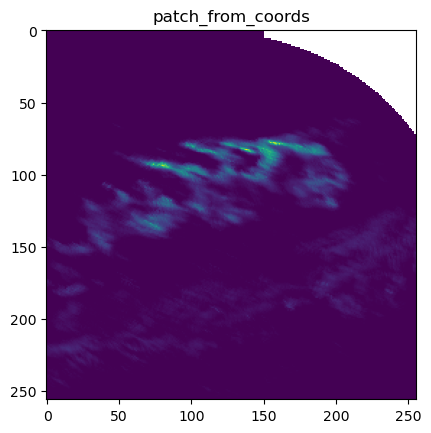

In [193]:
sample_block_vals = patch_from_coords.RV_recalc.values.squeeze()
plt.figure()
plt.title("patch_from_coords")
plt.imshow(sample_block_vals, cmap='viridis')

# group by day xarray --> group by day to split in training and validation

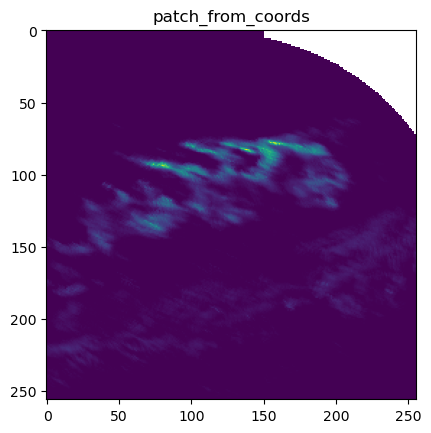

In [194]:
sample_block_vals = patch.RV_recalc.values.squeeze()
plt.figure()
plt.title("patch_from_coords")
plt.imshow(sample_block_vals, cmap='viridis')

# group by day xarray --> group by day to split in training and validation

### Try to understand data structure


In [195]:
data_shortened

<xarray.Dataset> Size: 3GB
Dimensions:                 (time: 567, y: 1200, x: 1100)
Coordinates:
    latitude                (y, x) float64 11MB ...
    longitude               (y, x) float64 11MB ...
    missing_data_RV_recalc  (time) float32 2kB ...
    step                    timedelta64[ns] 8B 00:00:00
  * time                    (time) datetime64[ns] 5kB 2019-01-01T00:40:00 ......
  * x                       (x) float64 9kB -543.5 -542.5 -541.5 ... 554.5 555.5
  * y                       (y) float64 10kB -3.61e+03 -3.611e+03 ... -4.809e+03
Data variables:
    RV_recalc               (time, y, x) float32 3GB ...
Attributes:
    crs:        +proj=stere +lat_0=90 +lat_ts=90 +lon_0=10 +k=0.93301270189 +...
    nodata:     nan
    notes:      The grid point RV_recalc[0,0] corresponds to the top-left cor...
    transform:  [1.0, 0.0, -543.4621669218559, 0.0, -1.0, -3609.644724265573]

##### Converting between np indecies to coords

In [196]:
time_value = data_shortened.time.isel(time=500).values
y_value = data_shortened.y.isel(y=600).values
x_value = data_shortened.x.isel(x=600).values

In [197]:
time_value, y_value, x_value

(np.datetime64('2019-01-02T18:20:00.000000000'),
 array(-4209.64472427),
 array(56.53783308))

In [198]:
data_shortened.sel(
    time = time_value,
    y = y_value,
    x = x_value,
).RV_recalc.values

array(0.1164, dtype=float32)

In [199]:
data_shortened.isel(
    time = 500,
    y = 600,
    x = 600,
).RV_recalc.values

array(0.1164, dtype=float32)

##### What does transform do?

In [200]:
data_cropped = data_shortened.isel(
    time = 0,
    y = slice(20, 30),
    x = slice(20, 30),
)

In [201]:
data_cropped.transform

[1.0, 0.0, -543.4621669218559, 0.0, -1.0, -3609.644724265573]

In [202]:
data_shortened.transform

[1.0, 0.0, -543.4621669218559, 0.0, -1.0, -3609.644724265573]

Transforms are equal for cropped and original data set
--> It cannot be that the transform directly converts from np pixel space to coordinates, as when cropping the [0,0] reference changes in the numpy pixel indecies

In [203]:
a,b,c,d,e,f = data_shortened.transform

##### What does lat / lon do?
Comment:
X und Y beinhaltet ja die Daten, innerhalb des von uns definierten Koordinatensystems. 
Ich hätte gedacht dass jeder Datenpunkt innerhalb von x und y ein lat / lon pair haben müsste. 
Unter 'longitude' hat jeder Datenpunk allerdings ein x, y pair in unserem Koordinatensystem unter 'latitude' hat auch jeder datenpunkt ein x,y pair ... Macht irgendwie keinen Sinn für mich, was hat das mit latitude / longitude zu tun? 

In [204]:
data_shortened.longitude.y[0]

<xarray.DataArray 'y' ()> Size: 8B
array(-3609.64472427)
Coordinates:
    step     timedelta64[ns] 8B 00:00:00
    y        float64 8B -3.61e+03

In [205]:
data_shortened.longitude.x[0]

<xarray.DataArray 'x' ()> Size: 8B
array(-543.46216692)
Coordinates:
    step     timedelta64[ns] 8B 00:00:00
    x        float64 8B -543.5

In [206]:
data_shortened.latitude[0].y

<xarray.DataArray 'y' ()> Size: 8B
array(-3609.64472427)
Coordinates:
    step     timedelta64[ns] 8B 00:00:00
    y        float64 8B -3.61e+03

In [207]:
data_shortened.latitude[0].x

<xarray.DataArray 'x' (x: 1100)> Size: 9kB
array([-543.462167, -542.462167, -541.462167, ...,  553.537833,  554.537833,
        555.537833])
Coordinates:
    latitude   (x) float64 9kB ...
    longitude  (x) float64 9kB ...
    step       timedelta64[ns] 8B 00:00:00
  * x          (x) float64 9kB -543.5 -542.5 -541.5 -540.5 ... 553.5 554.5 555.5
    y          float64 8B -3.61e+03

### Test Filter

In [208]:
# Test filter on all samples
for i in range(valid_target_indecies_outer.shape[0]):
# i = 1
    coord = valid_target_indecies_outer[i, :]
    block = patches.isel(
        time = coord[0],
        y_outer = coord[1],
        x_outer = coord[2])
    block = block.squeeze()
    block_vals = block.RV_recalc.values
    
    pixel_over_thres_ratio = (block_vals > threshold_mm_rain_each_pixel).sum() / len(sample_block_vals)
    if pixel_over_thres_ratio < threshold_percentage_pixels:
        print(f'Ratio is {pixel_over_thres_ratio} which is below {threshold_percentage_pixels}')